# PART 1: Data Cleaning and Processing

Haoyu Yue, Department of Urban Design and Planning, University of Washington

We use Projected CRS, EPSG:3857, Name: WGS 84 / Pseudo-Mercator as main CRS. (From original investment dataset.)

## Preparation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar


In [3]:
#%matplotlib widget
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)

### Import Datasets

In [5]:
#spatial carbon investment data (location)
ca_line = gpd.read_file('data/capubdata/ca_line.gpkg')
ca_point = gpd.read_file('data/capubdata/ca_point.gpkg')
ca_polygon = gpd.read_file('data/capubdata/ca_polygon.gpkg')

#carbon investment detailed data
cci = pd.read_csv('data/cci_2021_all.csv')

/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_54197/831126720.py:7: DtypeWarning: Columns (1,7,15,19,21,22,23,47,55,100,101,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  cci = pd.read_csv('data/cci_2021_all.csv')


In [6]:
#administration boundairs
sf_boundary = gpd.read_file('data/sf_boundaries.gpkg')
sf_boundary = sf_boundary.to_crs('EPSG:3857')

In [7]:
#census block group
ca_bg = gpd.read_file('data/tl_2015_06_bg/tl_2015_06_bg.shp')
ca_bg = ca_bg.to_crs('EPSG:3857')

In [8]:
#population information from ACS 2019 5-year
ca_popu = pd.read_csv('data/ACSDT5Y_TotalPopulation_CA.csv')

### Define Global Varibales

In [9]:
SFMSA = ["San Francisco","Marin","Contra Costa","Alameda","San Mateo"] #the names of 5 counties
SFMSABOUNDARY = sf_boundary.total_bounds #the boundary of SF MSA
SFMSA_EXTENT = [-13694976,-13521897,4454076,4624901] 
YEARS = ['2015','2016','2017','2018','2019','2020',2015,2016,2017,2018,2019,2020] #six research years

### Carbon Ivestment Data Prep

In [10]:
#convert the ProjectID to string and select data within the research years
cci['ProjectIDNumber'] = cci['ProjectIDNumber'].astype(str) 
cci['ReportingCycleName'] = cci['ReportingCycleName'].astype(str) #convert to string
cci_in_years = cci[cci['ReportingCycleName'].isin(YEARS)] #select in the specific years

### Repeated Elements
In our spatial dataset, there are many projects occur more than one time so we need to come up with this issue. 

In [ ]:
repeat_line_poly = ca_line.merge(ca_polygon,how='inner',left_on='proj_id',right_on='proj_id').proj_id.unique()
repeat_point_poly = ca_point.merge(ca_polygon,how='inner',left_on='proj_id',right_on='proj_id').proj_id.unique()
repeat_line_point = ca_line.merge(ca_point,how='inner',left_on='proj_id',right_on='proj_id').proj_id.unique()

## Line Projects Data

### Get the shape for each line proj and Intersect the portion within research area/SF
We need to disslove all line projects and calculate the amount of investment within SF MSA based on the proportion.

In [14]:
ca_line_dissolve = ca_line.dissolve(by='proj_id')

In [18]:
for i in ca_line_dissolve.index.unique():
    ca_line_dissolve.loc[i,'Shape_Length'] = ca_line_dissolve[ca_line_dissolve.index==i].geometry.length[0]   

In [19]:
sf_line = ca_line_dissolve.clip(sf_boundary) #clip the lines within SF

In [20]:
sf_line['Length_SF'] = np.nan #create a new column for length
sf_line['Percentage_in_SF'] = np.nan #create a new column for percentage of line within SF (what percentage of this project is within research area)

In [21]:
for i in sf_line.index.unique():
    sf_line.loc[i,'Length_SF'] = sf_line[sf_line.index==i].geometry.length[0]
    sf_line.loc[i,'Percentage_in_SF'] = sf_line.loc[i,'Length_SF']/sf_line.loc[i,'Shape_Length']

In [22]:
sf_line = sf_line.reset_index()

In [23]:
sf_line_npreduplicate = sf_line
#sf_line_npreduplicate = sf_line[~(sf_line['proj_id']=='0019000134')]#this proj is existing in all three kinds of data

### Merge with `cci` dataset (detailed proj info)

In [24]:
sf_line_npreduplicate['proj_id'] = sf_line_npreduplicate['proj_id'].astype(str)
sf_line_npreduplicate['proj_id'] = sf_line_npreduplicate['proj_id'].str.lstrip('0')#make sure all project ids are string as common columns

In [25]:
cci_line_in_SF = cci_in_years[cci_in_years['ProjectIDNumber'].isin(list(sf_line_npreduplicate.proj_id.unique()))]

In [26]:
sf_line_npreduplicate_geo = sf_line_npreduplicate[['proj_id', 'geometry','Shape_Length','Length_SF','Percentage_in_SF']] #only select geometry and proj_id

In [30]:
sf_line_invest_geo = sf_line_npreduplicate_geo.merge(cci_line_in_SF,left_on='proj_id',right_on='ProjectIDNumber',how='outer') #year * proj = a row

In [31]:
sf_line_invest_geo['FundingSF'] = sf_line_invest_geo['TotalProgramGGRFFunding'] * sf_line_invest_geo['Percentage_in_SF']

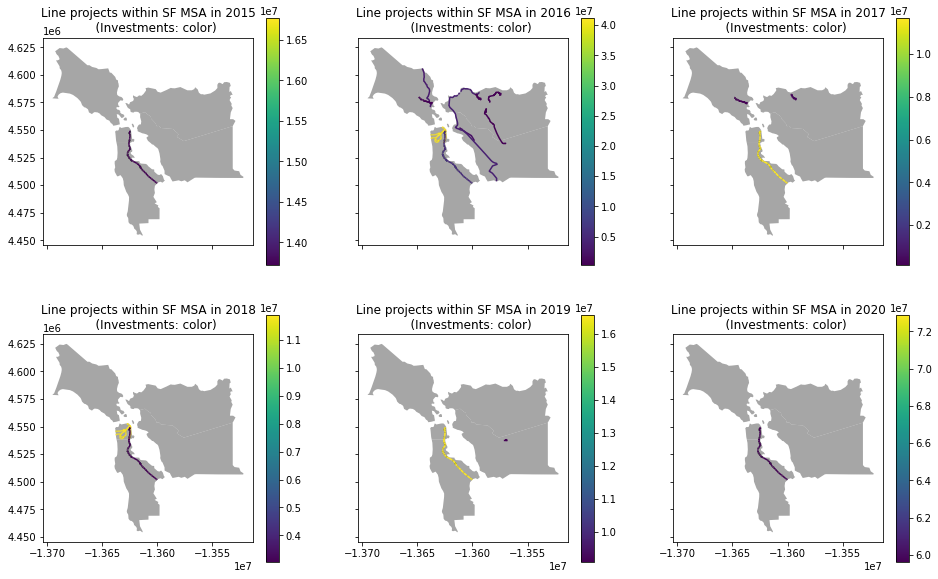

In [117]:
f,axs = plt.subplots(2,3,figsize=(16,10),sharex=True,sharey=True)
for ax,y in zip(axs.flat,YEARS):
    sf_boundary.plot(ax=ax,color='gray',alpha=0.7)
    sf_line_invest_geo[sf_line_invest_geo.ReportingCycleName==y].plot(ax=ax,column='FundingSF',legend=True)
    ax.set_title(f'''Line projects within SF MSA in {y}
    (Investments: color)''')
plt.show()

In [1]:
#The processing result dataset is `sf_line_invest_geo` and we need to allocate them in the future.
#sf_line_invest_geo.to_csv('data/01finished/sf_line.csv') 
sf_line_invest_geo.to_file('data/sf_project/sf_line.geojson', driver='GeoJSON')

NameError: name 'sf_line_invest_geo' is not defined

## Polygon Projects Data Processing


In [100]:
ca_polygon.proj_id = ca_polygon.proj_id.str.lstrip('0') #make sure all project ids are string as common columns

In [102]:
ca_polygon_dissolve = ca_polygon.dissolve(by='proj_id') 

In [103]:
for i in ca_polygon_dissolve.index.unique():
    ca_polygon_dissolve.loc[i,'Shape_Area'] = ca_polygon_dissolve[ca_polygon_dissolve.index==i].geometry.area.values[0]   

In [104]:
ca_polygon_dissolve = ca_polygon_dissolve.reset_index()

In [106]:
sf_polygon = ca_polygon_dissolve.clip(sf_boundary)

In [107]:
sf_polygon[sf_polygon['proj_id'].isin(['0020000276', '16-17-D03-034', '16-17-D03-035',
                        '16-17-D05-060', '0019000134', 'G14-AQIP-01','0020000276', '15-16-D8-110'])].proj_id.unique() #check the replicated projects

array(['G14-AQIP-01'], dtype=object)

In [108]:
sf_polygon_npreduplicate = sf_polygon[~(sf_polygon['proj_id']=='G14-AQIP-01')] #this proj is existing in all three kinds of data

In [109]:
sf_polygon_npreduplicate.head(3)

,proj_id,geometry,OBJECTID,reportingcyclename,agency,role_subprogram_id,subprogram_name,proj_name,proj_desc,census_tract,total_ggrf_funding,est_ghg_reductions,proj_benefits_desc,senate_district,assembly_district,COUNTY_NAME,BENEFITS_PRIORITY_YN,Shape_Length,Shape_Area
55,15-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",98555,2017,Department of Community Services and Development,90,Large Multi-Family Energy Efficiency and Renew...,Large Multi-Family Energy Efficiency and Renew...,Provides incentives to multi-family low-income...,06029004701,360954.0,2128,"Energy savings, employment opportunities, loca...",14,32,Kern,Yes,15228.246910,3.332901e+09
60,15S2-3-31,"MULTIPOLYGON (((-13626747.243 4549109.148, -13...",98193,2019,Department of Community Services and Development,90,Multi-Family Energy Efficiency and Renewables,Multi-Family Energy Efficiency and Renewables,Provides incentives to multi-family low-income...,06037239501,117533.0,483,"Energy savings, employment opportunities, loca...",30,59,Los Angeles,Yes,3887.257574,7.978858e+08
39,15-1-30,"MULTIPOLYGON (((-13619192.324 4569352.331, -13...",99308,2016,Department of Community Services and Development,88,Single-Family Energy Efficiency and Solar PV,Single Family/Small Multi-Family Energy Effici...,Provides single-family and small multi-family ...,06037575802,1187.0,4,"Energy savings, employment, training, improved...",33,70,Los Angeles,Yes,2903.499050,7.045420e+08


### Merge with `cci` data

In [110]:
sf_polygon_npreduplicate['proj_id'] = sf_polygon_npreduplicate['proj_id'].astype(str)
sf_polygon_npreduplicate['proj_id'] = sf_polygon_npreduplicate['proj_id'].str.lstrip('0')#make sure all project ids are string as common columns

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [111]:
cci_polygon_in_SF = cci_in_years[cci_in_years['ProjectIDNumber'].isin(list(sf_polygon_npreduplicate.proj_id.unique()))]

In [112]:
sf_polygon_npreduplicate_geo = sf_polygon_npreduplicate[['proj_id', 'geometry','Shape_Area']] #only select geometry and proj_id

In [113]:
sf_polygon_invest_geo = sf_polygon_npreduplicate_geo.merge(cci_polygon_in_SF,left_on='proj_id',right_on='ProjectIDNumber',how='outer')

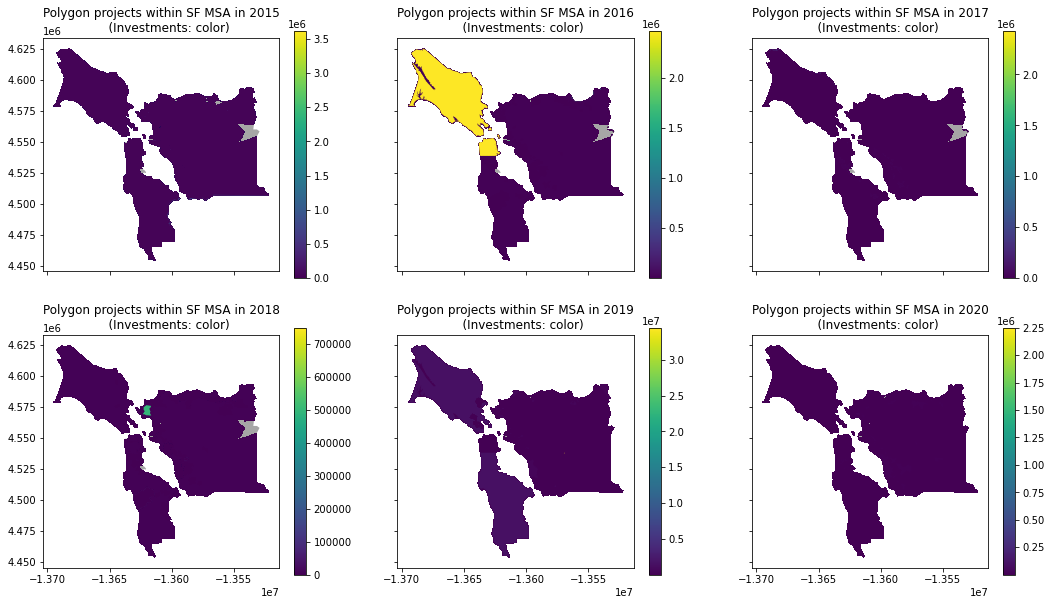

In [116]:
f,axs = plt.subplots(2,3,figsize=(18,10),sharex=True,sharey=True)
for ax,y in zip(axs.flat,YEARS):
    sf_boundary.plot(ax=ax,color='gray',alpha=0.7)
    sf_polygon_invest_geo[sf_polygon_invest_geo.ReportingCycleName==y].plot(ax=ax,column='TotalProjectCost',legend=True,alpha=0.5)
    ax.set_title(f'''Polygon projects within SF MSA in {y}
    (Investments: color)''')
plt.show()
#tons of overlap ploygons

In [80]:
#output
#sf_polygon_invest_geo.to_csv('data/01finished/sf_polygon.csv') 
sf_polygon_invest_geo.to_file('data/sf_project/sf_polygon.geojson', driver='GeoJSON')

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Point Projects Data Processing

In [128]:
ca_point_years = ca_point[ca_point.reportingcyclename.isin(YEARS)] 
ca_point_years['Funding'] = np.nan #select 

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [129]:
ca_point_reform = pd.DataFrame(columns=ca_point_years.columns)
for i in ca_point_years.proj_id.unique():
    df_proj = ca_point_years[ca_point_years.proj_id==i]
    for y in df_proj.reportingcyclename.unique():
        project_df = ca_point_years[(ca_point_years.proj_id==i)&(ca_point_years.reportingcyclename==y)]
        project_total_funding = ca_point_years[(ca_point_years.proj_id==i)&(ca_point_years.reportingcyclename==y)].total_ggrf_funding.iloc[0]
        project_number = len(ca_point_years[(ca_point_years.proj_id==i)&(ca_point_years.reportingcyclename==y)])
        project_df.loc[:,'Funding']=project_total_funding/project_number
        ca_point_reform = ca_point_reform.append(project_df)

/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_19994/1766571008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_df.loc[:,'Funding']=project_total_funding/project_number
/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_19994/1766571008.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ca_point_reform = ca_point_reform.append(project_df)
/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_19994/1766571008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

KeyboardInterrupt: 

In [ ]:
ca_point_reform = gpd.GeoDataFrame(ca_point_reform, geometry='geometry', crs=ca_point.crs) #convert from df to gdf

In [ ]:
sf_point = ca_point_reform.clip(sf_boundary) #clip the points within research area

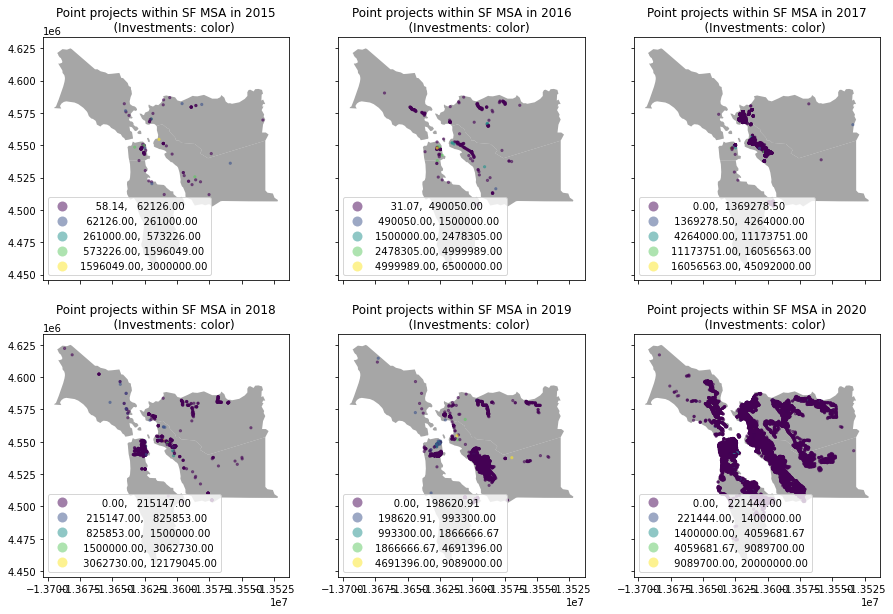

In [ ]:
#visualization
f,axs = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
for ax,y in zip(axs.flat,YEARS):
    sf_boundary.plot(ax=ax,color='gray',alpha=0.7)
    sf_point[sf_point.reportingcyclename==y].plot(ax=ax,column='Funding',markersize=5,legend=True,scheme='natural_breaks',alpha=0.5)
    ax.set_title(f'''Point projects within SF MSA in {y}
    (Investments: color)''')
plt.show()

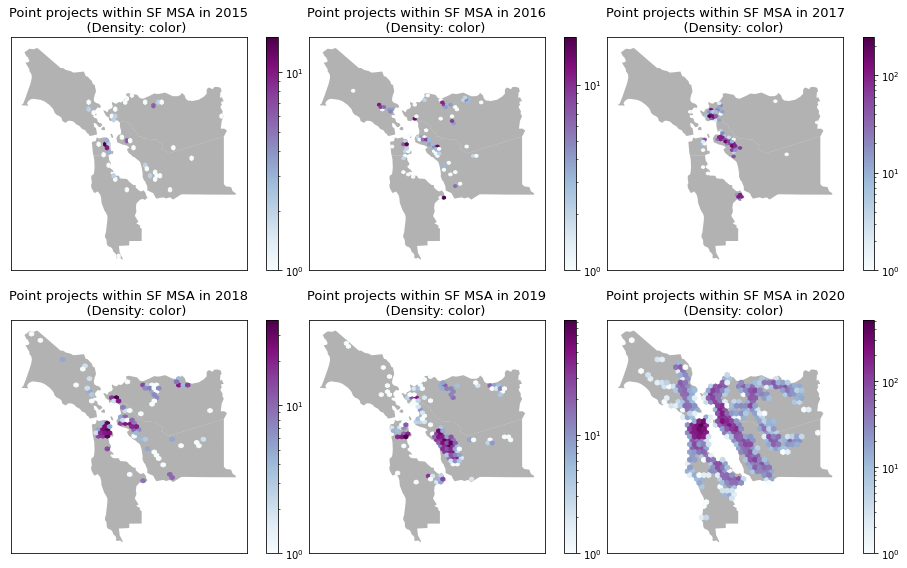

In [150]:
f,axs = plt.subplots(2,3,figsize=(14,8),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0,hspace=2)
for ax,y in zip(axs.flat,YEARS):
    data = sf_point[sf_point.reportingcyclename==y]
    sf_boundary.plot(ax=ax,color='gray',alpha=0.6)
    hb = ax.hexbin(data.geometry.x,data.geometry.y, gridsize=40, cmap='BuPu',mincnt=1,bins='log')
    ax.set_title(f'''Point projects within SF MSA in {y}
    (Density: color)''',size=13)
    plt.colorbar(hb,ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
f.tight_layout()
plt.show()


In [130]:
#sf_point.to_csv('data/01finished/sf_point.csv') 
#sf_point.to_file('data/sf_project/sf_point.geojson', driver='GeoJSON')
sf_point = gpd.read_file('data/sf_project/sf_point.geojson')

## Block Groups Data Processing

In [12]:
sf_bg = ca_bg.clip(sf_boundary)
sf_bg = sf_bg[(sf_bg.geometry.type != 'LineString')&(sf_bg.geometry.type != 'GeometryCollection')&(sf_bg.geometry.type != 'Point')]

In [13]:
sf_bg['area'] = sf_bg.geometry.area #get the area info for each cbg

In [14]:
ca_popu['geoid'] = ca_popu['id'].str.slice(-12,)

In [15]:
ca_popu_merge = ca_popu[['geoid','Estimate!!Total']]
ca_popu_merge.columns = ['geoid','TotalPopu'] #change the names of columns

In [16]:
sf_bg_popu = sf_bg.merge(ca_popu_merge,how='left',left_on='GEOID',right_on='geoid')

In [17]:
sf_bg_popu.to_file('data/sf_bg/sf_bg.geojson', driver='GeoJSON')

/Users/haoyu/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Research Area Visualization

(-13703630.309558578,
 -13513243.912907619,
 4445534.8668687865,
 4633443.056948734)

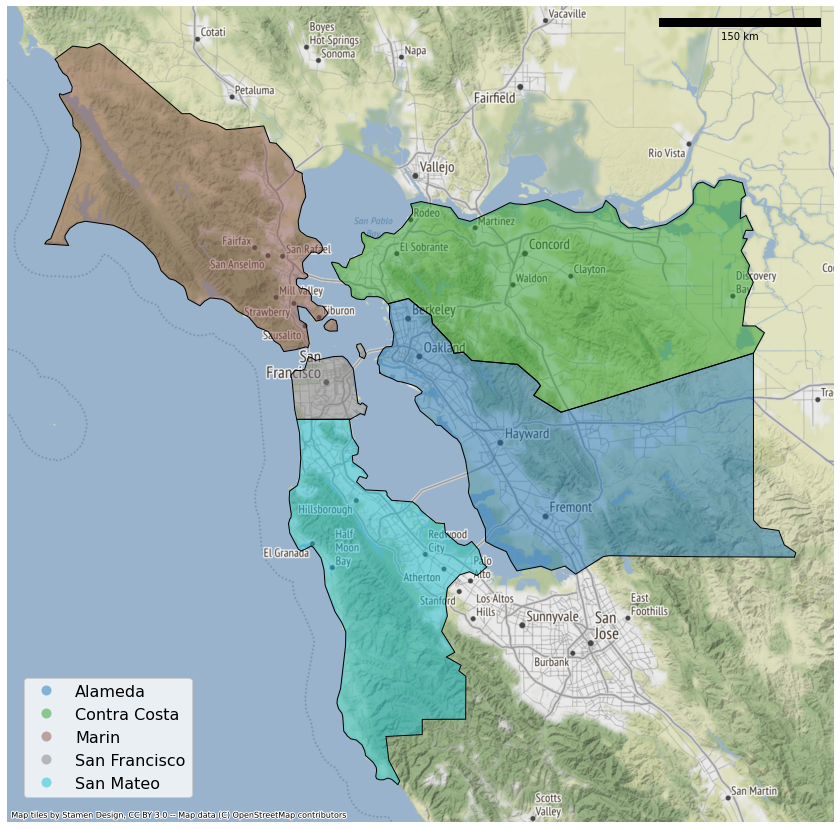

In [23]:
f, ax = plt.subplots(figsize=(15,15))
sf_boundary.plot(ax=ax,alpha=0.5,edgecolor="none",facecolor='red',column='NAME',legend=True,legend_kwds={'loc': [0.02,0.03],'fontsize':16})
sf_boundary.plot(ax=ax,edgecolor="black",facecolor='none')
ctx.add_basemap(ax=ax, crs=sf_bg_popu.crs, source=ctx.providers.Stamen.Terrain)
#ax.set_title('The Map of Study Area',size=18)
ax.add_artist(ScaleBar(4.0,box_alpha=0,border_pad=1))
plt.axis('off')

In [3]:
a = pd.read_csv('data/sf_project/sf_polygon.csv')

/var/folders/d4/7ds8vgb91y50k8cnmmtxccjr0000gn/T/ipykernel_5094/1385767540.py:1: DtypeWarning: Columns (11,12,15,16,19,23,24,25,26,27,51,54,58,59,64,104,109,110,118) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv('data/sf_project/sf_polygon.csv')
